In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/train-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/fashion-mnist_test.csv


In [2]:
from __future__ import print_function, division

from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU

import matplotlib.pyplot as plt
import sys
import numpy as np

Using TensorFlow backend.


In [7]:
### read dataset 
train = pd.read_csv("../input/fashionmnist/fashion-mnist_train.csv")
X_train = train[list(train.columns)[1:]].values
gen_imgs = np.array((25, 28, 28, 1))

In [10]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        #model.add(Dense(2048))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        #model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        #(X_train, _), (_, _) = fashion_mnist.load_data()
        train = pd.read_csv("../input/fashionmnist/fashion-mnist_train.csv")
        X_train = train[list(train.columns)[1:]].values

        X_train = np.reshape(X_train, (X_train.shape[0], 28, 28, 1))
        
        # Rescale train images -1 to 1
        X_train = X_train / 127.5 - 1.
        #X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if (epoch % sample_interval == 0) or (epoch == 2999):
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("images/%d.png" % epoch)
        plt.show()
        plt.close()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

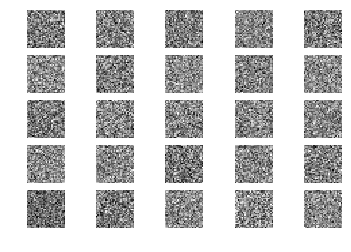

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.471869, acc.: 64.06%] [G loss: 0.653215]
2 [D loss: 0.409069, acc.: 67.19%] [G loss: 0.621909]
3 [D loss: 0.384355, acc.: 68.75%] [G loss: 0.733569]
4 [D loss: 0.369484, acc.: 76.56%] [G loss: 0.785215]
5 [D loss: 0.334839, acc.: 81.25%] [G loss: 0.925583]
6 [D loss: 0.305026, acc.: 90.62%] [G loss: 1.010274]
7 [D loss: 0.247640, acc.: 100.00%] [G loss: 1.151298]
8 [D loss: 0.205515, acc.: 100.00%] [G loss: 1.338671]
9 [D loss: 0.195314, acc.: 100.00%] [G loss: 1.537112]
10 [D loss: 0.150507, acc.: 100.00%] [G loss: 1.652484]
11 [D loss: 0.150909, acc.: 98.44%] [G loss: 1.751763]
12 [D loss: 0.129068, acc.: 100.00%] [G loss: 1.819625]
13 [D loss: 0.116910, acc.: 100.00%] [G loss: 2.034933]
14 [D loss: 0.115902, acc.: 100.00%] [G loss: 2.211895]
15 [D loss: 0.087576, acc.: 100.00%] [G loss: 2.277234]
16 [D loss: 0.089453, acc.: 100.00%] [G loss: 2.340927]
17 [D loss: 0.086352, acc.: 98.44%] [G loss: 2.485060]
18 [D loss: 0.096300, acc.: 100.00%] [G loss: 2.448322]
19 [D los

148 [D loss: 0.160235, acc.: 95.31%] [G loss: 4.168785]
149 [D loss: 0.140444, acc.: 95.31%] [G loss: 3.682100]
150 [D loss: 0.085324, acc.: 98.44%] [G loss: 3.630220]
151 [D loss: 0.114074, acc.: 95.31%] [G loss: 3.663486]
152 [D loss: 0.270137, acc.: 87.50%] [G loss: 3.509238]
153 [D loss: 0.198522, acc.: 87.50%] [G loss: 4.020871]
154 [D loss: 0.175339, acc.: 92.19%] [G loss: 3.990634]
155 [D loss: 0.142999, acc.: 93.75%] [G loss: 4.347878]
156 [D loss: 0.119442, acc.: 98.44%] [G loss: 3.667258]
157 [D loss: 0.080758, acc.: 96.88%] [G loss: 4.141569]
158 [D loss: 0.264518, acc.: 93.75%] [G loss: 3.768196]
159 [D loss: 0.109434, acc.: 95.31%] [G loss: 3.685332]
160 [D loss: 0.545167, acc.: 75.00%] [G loss: 2.798674]
161 [D loss: 0.126866, acc.: 93.75%] [G loss: 4.067215]
162 [D loss: 0.532566, acc.: 76.56%] [G loss: 2.889855]
163 [D loss: 0.099548, acc.: 100.00%] [G loss: 4.244747]
164 [D loss: 0.200585, acc.: 90.62%] [G loss: 4.019183]
165 [D loss: 0.130835, acc.: 96.88%] [G loss: 3

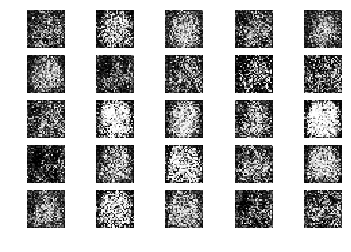

201 [D loss: 0.240842, acc.: 95.31%] [G loss: 3.788693]
202 [D loss: 0.824792, acc.: 65.62%] [G loss: 2.502962]
203 [D loss: 0.320176, acc.: 85.94%] [G loss: 3.739608]
204 [D loss: 0.506710, acc.: 73.44%] [G loss: 3.383778]
205 [D loss: 0.361548, acc.: 85.94%] [G loss: 3.669828]
206 [D loss: 0.654021, acc.: 76.56%] [G loss: 1.729999]
207 [D loss: 0.363870, acc.: 81.25%] [G loss: 2.810118]
208 [D loss: 0.380229, acc.: 85.94%] [G loss: 3.168743]
209 [D loss: 0.644949, acc.: 67.19%] [G loss: 2.454418]
210 [D loss: 0.244147, acc.: 92.19%] [G loss: 3.390442]
211 [D loss: 0.691083, acc.: 57.81%] [G loss: 2.155977]
212 [D loss: 0.381943, acc.: 79.69%] [G loss: 3.385782]
213 [D loss: 0.225006, acc.: 90.62%] [G loss: 2.880465]
214 [D loss: 0.826108, acc.: 57.81%] [G loss: 2.291852]
215 [D loss: 0.392028, acc.: 81.25%] [G loss: 3.018521]
216 [D loss: 0.959657, acc.: 60.94%] [G loss: 2.464826]
217 [D loss: 0.361798, acc.: 85.94%] [G loss: 2.308558]
218 [D loss: 0.565865, acc.: 67.19%] [G loss: 2.

352 [D loss: 0.573329, acc.: 70.31%] [G loss: 1.168335]
353 [D loss: 0.586491, acc.: 68.75%] [G loss: 1.223953]
354 [D loss: 0.565282, acc.: 70.31%] [G loss: 1.124259]
355 [D loss: 0.603990, acc.: 56.25%] [G loss: 1.040136]
356 [D loss: 0.595789, acc.: 68.75%] [G loss: 1.163095]
357 [D loss: 0.516458, acc.: 81.25%] [G loss: 1.211785]
358 [D loss: 0.613932, acc.: 73.44%] [G loss: 1.171465]
359 [D loss: 0.603201, acc.: 62.50%] [G loss: 1.190429]
360 [D loss: 0.593200, acc.: 67.19%] [G loss: 1.203482]
361 [D loss: 0.651411, acc.: 62.50%] [G loss: 1.161195]
362 [D loss: 0.722089, acc.: 56.25%] [G loss: 0.959670]
363 [D loss: 0.640555, acc.: 54.69%] [G loss: 1.133523]
364 [D loss: 0.700697, acc.: 60.94%] [G loss: 1.058043]
365 [D loss: 0.613584, acc.: 68.75%] [G loss: 1.070798]
366 [D loss: 0.609739, acc.: 62.50%] [G loss: 1.123059]
367 [D loss: 0.562263, acc.: 78.12%] [G loss: 1.105649]
368 [D loss: 0.723469, acc.: 51.56%] [G loss: 1.107369]
369 [D loss: 0.610186, acc.: 64.06%] [G loss: 1.

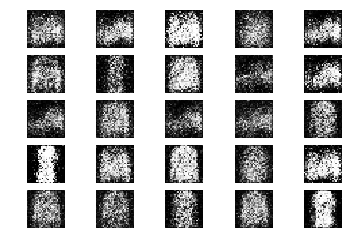

401 [D loss: 0.576806, acc.: 68.75%] [G loss: 1.032164]
402 [D loss: 0.600901, acc.: 64.06%] [G loss: 1.046922]
403 [D loss: 0.623555, acc.: 65.62%] [G loss: 1.076609]
404 [D loss: 0.651303, acc.: 68.75%] [G loss: 1.087928]
405 [D loss: 0.575730, acc.: 73.44%] [G loss: 0.952096]
406 [D loss: 0.617887, acc.: 60.94%] [G loss: 0.974152]
407 [D loss: 0.648952, acc.: 62.50%] [G loss: 1.093659]
408 [D loss: 0.636905, acc.: 64.06%] [G loss: 1.021963]
409 [D loss: 0.624941, acc.: 67.19%] [G loss: 1.143368]
410 [D loss: 0.666003, acc.: 62.50%] [G loss: 1.101325]
411 [D loss: 0.598197, acc.: 70.31%] [G loss: 1.026472]
412 [D loss: 0.622029, acc.: 65.62%] [G loss: 0.931027]
413 [D loss: 0.659000, acc.: 64.06%] [G loss: 0.938591]
414 [D loss: 0.546586, acc.: 75.00%] [G loss: 0.907975]
415 [D loss: 0.662618, acc.: 57.81%] [G loss: 1.010623]
416 [D loss: 0.538218, acc.: 75.00%] [G loss: 1.096729]
417 [D loss: 0.637714, acc.: 62.50%] [G loss: 1.146756]
418 [D loss: 0.591567, acc.: 73.44%] [G loss: 1.

553 [D loss: 0.667856, acc.: 54.69%] [G loss: 0.890920]
554 [D loss: 0.577233, acc.: 65.62%] [G loss: 0.996351]
555 [D loss: 0.609233, acc.: 65.62%] [G loss: 0.993493]
556 [D loss: 0.599647, acc.: 68.75%] [G loss: 1.077806]
557 [D loss: 0.604290, acc.: 70.31%] [G loss: 1.048747]
558 [D loss: 0.549563, acc.: 73.44%] [G loss: 1.033324]
559 [D loss: 0.585656, acc.: 70.31%] [G loss: 1.021610]
560 [D loss: 0.546639, acc.: 71.88%] [G loss: 1.035620]
561 [D loss: 0.720482, acc.: 57.81%] [G loss: 0.992162]
562 [D loss: 0.616493, acc.: 62.50%] [G loss: 0.919018]
563 [D loss: 0.608991, acc.: 76.56%] [G loss: 0.867807]
564 [D loss: 0.596761, acc.: 70.31%] [G loss: 0.937371]
565 [D loss: 0.691846, acc.: 53.12%] [G loss: 0.886826]
566 [D loss: 0.603403, acc.: 67.19%] [G loss: 1.023167]
567 [D loss: 0.745463, acc.: 54.69%] [G loss: 0.992237]
568 [D loss: 0.606879, acc.: 62.50%] [G loss: 0.911318]
569 [D loss: 0.540983, acc.: 75.00%] [G loss: 1.086446]
570 [D loss: 0.630083, acc.: 65.62%] [G loss: 1.

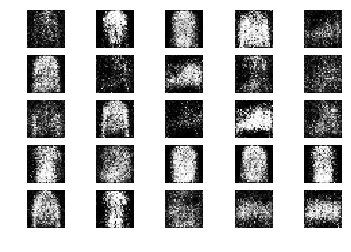

601 [D loss: 0.638074, acc.: 65.62%] [G loss: 0.916133]
602 [D loss: 0.578276, acc.: 70.31%] [G loss: 1.020218]
603 [D loss: 0.660207, acc.: 62.50%] [G loss: 1.051838]
604 [D loss: 0.656419, acc.: 60.94%] [G loss: 0.982232]
605 [D loss: 0.577352, acc.: 73.44%] [G loss: 1.043655]
606 [D loss: 0.663366, acc.: 62.50%] [G loss: 0.995498]
607 [D loss: 0.653480, acc.: 64.06%] [G loss: 0.862192]
608 [D loss: 0.606951, acc.: 65.62%] [G loss: 0.842468]
609 [D loss: 0.636466, acc.: 60.94%] [G loss: 0.968949]
610 [D loss: 0.613088, acc.: 76.56%] [G loss: 0.838795]
611 [D loss: 0.653223, acc.: 54.69%] [G loss: 0.915564]
612 [D loss: 0.626414, acc.: 62.50%] [G loss: 0.855848]
613 [D loss: 0.658072, acc.: 59.38%] [G loss: 1.015124]
614 [D loss: 0.616011, acc.: 71.88%] [G loss: 0.930136]
615 [D loss: 0.585904, acc.: 67.19%] [G loss: 0.967988]
616 [D loss: 0.623531, acc.: 67.19%] [G loss: 0.995192]
617 [D loss: 0.616500, acc.: 76.56%] [G loss: 0.841698]
618 [D loss: 0.685633, acc.: 51.56%] [G loss: 0.

751 [D loss: 0.604026, acc.: 62.50%] [G loss: 0.867322]
752 [D loss: 0.596385, acc.: 64.06%] [G loss: 0.949390]
753 [D loss: 0.582159, acc.: 67.19%] [G loss: 0.939070]
754 [D loss: 0.652946, acc.: 57.81%] [G loss: 0.918808]
755 [D loss: 0.659699, acc.: 57.81%] [G loss: 0.929836]
756 [D loss: 0.651035, acc.: 60.94%] [G loss: 0.957468]
757 [D loss: 0.646077, acc.: 67.19%] [G loss: 0.941279]
758 [D loss: 0.628998, acc.: 59.38%] [G loss: 0.908220]
759 [D loss: 0.665885, acc.: 60.94%] [G loss: 0.904628]
760 [D loss: 0.626591, acc.: 68.75%] [G loss: 0.859481]
761 [D loss: 0.640526, acc.: 65.62%] [G loss: 0.880223]
762 [D loss: 0.627574, acc.: 60.94%] [G loss: 0.808132]
763 [D loss: 0.593414, acc.: 67.19%] [G loss: 0.914920]
764 [D loss: 0.554828, acc.: 71.88%] [G loss: 0.798087]
765 [D loss: 0.680527, acc.: 59.38%] [G loss: 0.928661]
766 [D loss: 0.576024, acc.: 73.44%] [G loss: 0.900599]
767 [D loss: 0.566010, acc.: 70.31%] [G loss: 0.856230]
768 [D loss: 0.606013, acc.: 60.94%] [G loss: 0.

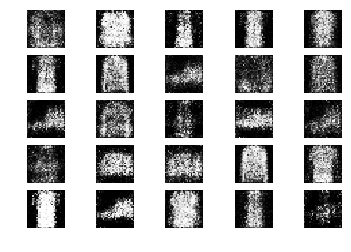

801 [D loss: 0.605382, acc.: 70.31%] [G loss: 0.899887]
802 [D loss: 0.692726, acc.: 56.25%] [G loss: 0.773670]
803 [D loss: 0.666967, acc.: 57.81%] [G loss: 0.714119]
804 [D loss: 0.641501, acc.: 62.50%] [G loss: 0.841118]
805 [D loss: 0.657726, acc.: 59.38%] [G loss: 0.849581]
806 [D loss: 0.633391, acc.: 62.50%] [G loss: 0.881622]
807 [D loss: 0.595082, acc.: 68.75%] [G loss: 0.855718]
808 [D loss: 0.618179, acc.: 64.06%] [G loss: 0.893908]
809 [D loss: 0.624966, acc.: 64.06%] [G loss: 0.890964]
810 [D loss: 0.629062, acc.: 67.19%] [G loss: 0.832693]
811 [D loss: 0.552348, acc.: 71.88%] [G loss: 0.892715]
812 [D loss: 0.606281, acc.: 68.75%] [G loss: 0.944078]
813 [D loss: 0.586602, acc.: 73.44%] [G loss: 0.946506]
814 [D loss: 0.641041, acc.: 59.38%] [G loss: 0.963749]
815 [D loss: 0.577299, acc.: 79.69%] [G loss: 0.896789]
816 [D loss: 0.647746, acc.: 65.62%] [G loss: 0.894364]
817 [D loss: 0.643686, acc.: 54.69%] [G loss: 0.929098]
818 [D loss: 0.583776, acc.: 70.31%] [G loss: 0.

950 [D loss: 0.650176, acc.: 60.94%] [G loss: 0.808731]
951 [D loss: 0.622361, acc.: 67.19%] [G loss: 0.863233]
952 [D loss: 0.587768, acc.: 73.44%] [G loss: 0.886318]
953 [D loss: 0.691097, acc.: 60.94%] [G loss: 0.910330]
954 [D loss: 0.690254, acc.: 56.25%] [G loss: 0.907415]
955 [D loss: 0.643870, acc.: 57.81%] [G loss: 0.927802]
956 [D loss: 0.634157, acc.: 73.44%] [G loss: 0.965585]
957 [D loss: 0.667006, acc.: 51.56%] [G loss: 0.873638]
958 [D loss: 0.600284, acc.: 62.50%] [G loss: 0.974236]
959 [D loss: 0.650917, acc.: 54.69%] [G loss: 0.945150]
960 [D loss: 0.640970, acc.: 71.88%] [G loss: 0.895655]
961 [D loss: 0.615968, acc.: 70.31%] [G loss: 0.887588]
962 [D loss: 0.727970, acc.: 54.69%] [G loss: 0.885771]
963 [D loss: 0.665221, acc.: 56.25%] [G loss: 0.863301]
964 [D loss: 0.598749, acc.: 59.38%] [G loss: 0.972617]
965 [D loss: 0.641806, acc.: 59.38%] [G loss: 0.963863]
966 [D loss: 0.586038, acc.: 67.19%] [G loss: 0.907175]
967 [D loss: 0.708920, acc.: 50.00%] [G loss: 0.

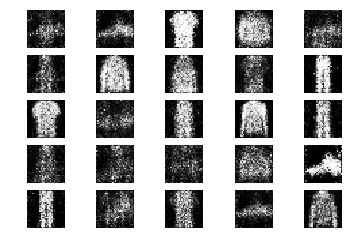

1001 [D loss: 0.618230, acc.: 70.31%] [G loss: 0.863667]
1002 [D loss: 0.631293, acc.: 70.31%] [G loss: 0.835600]
1003 [D loss: 0.659853, acc.: 60.94%] [G loss: 0.841691]
1004 [D loss: 0.654616, acc.: 56.25%] [G loss: 0.861329]
1005 [D loss: 0.682543, acc.: 59.38%] [G loss: 0.869958]
1006 [D loss: 0.608091, acc.: 71.88%] [G loss: 0.847619]
1007 [D loss: 0.685500, acc.: 60.94%] [G loss: 0.794161]
1008 [D loss: 0.673749, acc.: 57.81%] [G loss: 0.824853]
1009 [D loss: 0.699545, acc.: 56.25%] [G loss: 0.818048]
1010 [D loss: 0.631247, acc.: 60.94%] [G loss: 0.827112]
1011 [D loss: 0.701211, acc.: 53.12%] [G loss: 0.865598]
1012 [D loss: 0.732448, acc.: 50.00%] [G loss: 0.839895]
1013 [D loss: 0.622071, acc.: 62.50%] [G loss: 0.927128]
1014 [D loss: 0.675976, acc.: 62.50%] [G loss: 0.920690]
1015 [D loss: 0.679665, acc.: 60.94%] [G loss: 0.887668]
1016 [D loss: 0.637636, acc.: 64.06%] [G loss: 0.864011]
1017 [D loss: 0.616150, acc.: 62.50%] [G loss: 0.847198]
1018 [D loss: 0.668220, acc.: 5

1153 [D loss: 0.689999, acc.: 53.12%] [G loss: 0.806684]
1154 [D loss: 0.636776, acc.: 60.94%] [G loss: 0.807350]
1155 [D loss: 0.647281, acc.: 65.62%] [G loss: 0.860164]
1156 [D loss: 0.639468, acc.: 67.19%] [G loss: 0.794996]
1157 [D loss: 0.647932, acc.: 59.38%] [G loss: 0.868102]
1158 [D loss: 0.612925, acc.: 81.25%] [G loss: 0.893775]
1159 [D loss: 0.687350, acc.: 53.12%] [G loss: 0.854627]
1160 [D loss: 0.599915, acc.: 59.38%] [G loss: 0.885572]
1161 [D loss: 0.659462, acc.: 62.50%] [G loss: 0.857910]
1162 [D loss: 0.585538, acc.: 71.88%] [G loss: 0.842714]
1163 [D loss: 0.608827, acc.: 65.62%] [G loss: 0.838305]
1164 [D loss: 0.602851, acc.: 67.19%] [G loss: 0.813526]
1165 [D loss: 0.684383, acc.: 57.81%] [G loss: 0.830244]
1166 [D loss: 0.604362, acc.: 71.88%] [G loss: 0.996093]
1167 [D loss: 0.622002, acc.: 60.94%] [G loss: 0.822886]
1168 [D loss: 0.622102, acc.: 60.94%] [G loss: 0.869289]
1169 [D loss: 0.645919, acc.: 67.19%] [G loss: 0.873625]
1170 [D loss: 0.648020, acc.: 5

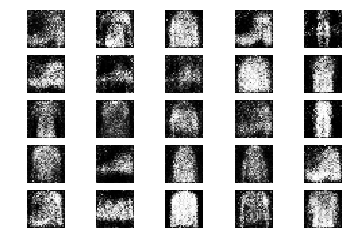

1201 [D loss: 0.660394, acc.: 64.06%] [G loss: 0.842991]
1202 [D loss: 0.582320, acc.: 73.44%] [G loss: 0.953816]
1203 [D loss: 0.666595, acc.: 60.94%] [G loss: 0.895711]
1204 [D loss: 0.623634, acc.: 67.19%] [G loss: 0.957851]
1205 [D loss: 0.676918, acc.: 54.69%] [G loss: 0.862521]
1206 [D loss: 0.660073, acc.: 59.38%] [G loss: 0.858430]
1207 [D loss: 0.680989, acc.: 65.62%] [G loss: 0.828449]
1208 [D loss: 0.685477, acc.: 54.69%] [G loss: 0.799677]
1209 [D loss: 0.731849, acc.: 46.88%] [G loss: 0.798630]
1210 [D loss: 0.651620, acc.: 62.50%] [G loss: 0.862437]
1211 [D loss: 0.627336, acc.: 65.62%] [G loss: 0.779204]
1212 [D loss: 0.658951, acc.: 54.69%] [G loss: 0.872912]
1213 [D loss: 0.655363, acc.: 62.50%] [G loss: 0.897835]
1214 [D loss: 0.678705, acc.: 62.50%] [G loss: 0.864666]
1215 [D loss: 0.611775, acc.: 71.88%] [G loss: 0.796944]
1216 [D loss: 0.623308, acc.: 68.75%] [G loss: 0.822944]
1217 [D loss: 0.641594, acc.: 62.50%] [G loss: 0.851996]
1218 [D loss: 0.600130, acc.: 7

1350 [D loss: 0.609130, acc.: 68.75%] [G loss: 0.873801]
1351 [D loss: 0.623514, acc.: 60.94%] [G loss: 0.868715]
1352 [D loss: 0.642201, acc.: 68.75%] [G loss: 0.926002]
1353 [D loss: 0.662868, acc.: 64.06%] [G loss: 0.949823]
1354 [D loss: 0.704746, acc.: 56.25%] [G loss: 0.943681]
1355 [D loss: 0.612620, acc.: 68.75%] [G loss: 0.852410]
1356 [D loss: 0.586670, acc.: 70.31%] [G loss: 0.806549]
1357 [D loss: 0.575556, acc.: 73.44%] [G loss: 0.829378]
1358 [D loss: 0.575735, acc.: 71.88%] [G loss: 0.801446]
1359 [D loss: 0.604368, acc.: 70.31%] [G loss: 0.890143]
1360 [D loss: 0.644970, acc.: 60.94%] [G loss: 0.892874]
1361 [D loss: 0.647291, acc.: 57.81%] [G loss: 0.822845]
1362 [D loss: 0.615133, acc.: 68.75%] [G loss: 0.855827]
1363 [D loss: 0.609827, acc.: 67.19%] [G loss: 0.885896]
1364 [D loss: 0.610637, acc.: 67.19%] [G loss: 0.884253]
1365 [D loss: 0.688278, acc.: 53.12%] [G loss: 0.787536]
1366 [D loss: 0.632236, acc.: 65.62%] [G loss: 0.807679]
1367 [D loss: 0.555510, acc.: 7

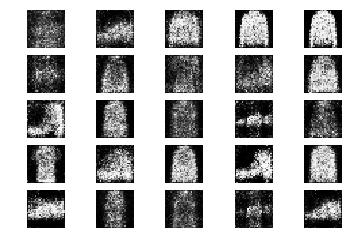

1401 [D loss: 0.641531, acc.: 60.94%] [G loss: 0.865396]
1402 [D loss: 0.559788, acc.: 73.44%] [G loss: 0.924127]
1403 [D loss: 0.601372, acc.: 64.06%] [G loss: 0.916291]
1404 [D loss: 0.690233, acc.: 56.25%] [G loss: 0.947925]
1405 [D loss: 0.649436, acc.: 64.06%] [G loss: 0.925517]
1406 [D loss: 0.678875, acc.: 51.56%] [G loss: 0.857952]
1407 [D loss: 0.580856, acc.: 71.88%] [G loss: 0.821275]
1408 [D loss: 0.705265, acc.: 56.25%] [G loss: 0.884044]
1409 [D loss: 0.666623, acc.: 54.69%] [G loss: 0.770263]
1410 [D loss: 0.637154, acc.: 71.88%] [G loss: 0.804756]
1411 [D loss: 0.700483, acc.: 56.25%] [G loss: 0.916531]
1412 [D loss: 0.663066, acc.: 64.06%] [G loss: 0.834766]
1413 [D loss: 0.622304, acc.: 68.75%] [G loss: 0.929171]
1414 [D loss: 0.628837, acc.: 64.06%] [G loss: 0.871209]
1415 [D loss: 0.634219, acc.: 59.38%] [G loss: 0.892055]
1416 [D loss: 0.617042, acc.: 60.94%] [G loss: 0.929534]
1417 [D loss: 0.561114, acc.: 70.31%] [G loss: 0.909855]
1418 [D loss: 0.703842, acc.: 5

1553 [D loss: 0.616623, acc.: 65.62%] [G loss: 0.892107]
1554 [D loss: 0.622182, acc.: 68.75%] [G loss: 0.776071]
1555 [D loss: 0.667898, acc.: 68.75%] [G loss: 0.891323]
1556 [D loss: 0.661980, acc.: 65.62%] [G loss: 0.825610]
1557 [D loss: 0.606740, acc.: 73.44%] [G loss: 0.892287]
1558 [D loss: 0.624381, acc.: 68.75%] [G loss: 0.913143]
1559 [D loss: 0.610587, acc.: 75.00%] [G loss: 0.859699]
1560 [D loss: 0.657979, acc.: 65.62%] [G loss: 0.853505]
1561 [D loss: 0.642926, acc.: 60.94%] [G loss: 0.803275]
1562 [D loss: 0.687099, acc.: 57.81%] [G loss: 0.814318]
1563 [D loss: 0.611166, acc.: 70.31%] [G loss: 0.911018]
1564 [D loss: 0.678794, acc.: 62.50%] [G loss: 0.868956]
1565 [D loss: 0.630160, acc.: 71.88%] [G loss: 0.949152]
1566 [D loss: 0.681385, acc.: 54.69%] [G loss: 0.934079]
1567 [D loss: 0.613837, acc.: 70.31%] [G loss: 0.911866]
1568 [D loss: 0.626177, acc.: 67.19%] [G loss: 0.947363]
1569 [D loss: 0.655661, acc.: 59.38%] [G loss: 0.903394]
1570 [D loss: 0.664286, acc.: 5

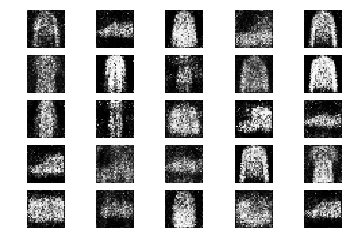

1601 [D loss: 0.624240, acc.: 62.50%] [G loss: 1.011778]
1602 [D loss: 0.709643, acc.: 50.00%] [G loss: 0.833355]
1603 [D loss: 0.594214, acc.: 70.31%] [G loss: 0.820235]
1604 [D loss: 0.693798, acc.: 57.81%] [G loss: 0.951750]
1605 [D loss: 0.640872, acc.: 62.50%] [G loss: 0.970290]
1606 [D loss: 0.624996, acc.: 64.06%] [G loss: 0.888938]
1607 [D loss: 0.614147, acc.: 64.06%] [G loss: 0.945782]
1608 [D loss: 0.621190, acc.: 62.50%] [G loss: 0.921957]
1609 [D loss: 0.648637, acc.: 65.62%] [G loss: 0.900444]
1610 [D loss: 0.612287, acc.: 67.19%] [G loss: 0.864640]
1611 [D loss: 0.606750, acc.: 64.06%] [G loss: 0.845465]
1612 [D loss: 0.634659, acc.: 59.38%] [G loss: 0.871131]
1613 [D loss: 0.621128, acc.: 64.06%] [G loss: 0.901823]
1614 [D loss: 0.618777, acc.: 65.62%] [G loss: 0.865776]
1615 [D loss: 0.650282, acc.: 56.25%] [G loss: 0.911809]
1616 [D loss: 0.634389, acc.: 67.19%] [G loss: 0.832119]
1617 [D loss: 0.658768, acc.: 65.62%] [G loss: 0.911583]
1618 [D loss: 0.654290, acc.: 6

1751 [D loss: 0.597530, acc.: 68.75%] [G loss: 0.858232]
1752 [D loss: 0.668407, acc.: 59.38%] [G loss: 0.950210]
1753 [D loss: 0.646926, acc.: 64.06%] [G loss: 0.813222]
1754 [D loss: 0.614195, acc.: 65.62%] [G loss: 0.901553]
1755 [D loss: 0.607571, acc.: 65.62%] [G loss: 0.954393]
1756 [D loss: 0.652785, acc.: 59.38%] [G loss: 0.956977]
1757 [D loss: 0.669472, acc.: 59.38%] [G loss: 0.988674]
1758 [D loss: 0.659798, acc.: 60.94%] [G loss: 0.919485]
1759 [D loss: 0.598042, acc.: 65.62%] [G loss: 0.901411]
1760 [D loss: 0.615706, acc.: 64.06%] [G loss: 0.888977]
1761 [D loss: 0.666840, acc.: 57.81%] [G loss: 0.907961]
1762 [D loss: 0.645031, acc.: 56.25%] [G loss: 0.916629]
1763 [D loss: 0.625222, acc.: 68.75%] [G loss: 0.862929]
1764 [D loss: 0.615010, acc.: 68.75%] [G loss: 0.833696]
1765 [D loss: 0.689991, acc.: 60.94%] [G loss: 0.806053]
1766 [D loss: 0.697558, acc.: 54.69%] [G loss: 0.891480]
1767 [D loss: 0.560248, acc.: 68.75%] [G loss: 0.888326]
1768 [D loss: 0.630619, acc.: 5

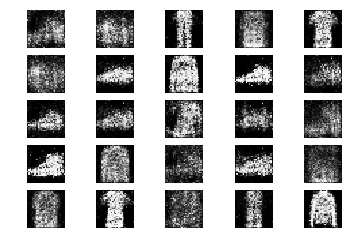

1801 [D loss: 0.557102, acc.: 76.56%] [G loss: 0.944645]
1802 [D loss: 0.624623, acc.: 67.19%] [G loss: 0.834672]
1803 [D loss: 0.604935, acc.: 71.88%] [G loss: 1.014246]
1804 [D loss: 0.617514, acc.: 64.06%] [G loss: 0.936658]
1805 [D loss: 0.661340, acc.: 60.94%] [G loss: 0.803692]
1806 [D loss: 0.619554, acc.: 59.38%] [G loss: 0.814749]
1807 [D loss: 0.640764, acc.: 62.50%] [G loss: 0.899853]
1808 [D loss: 0.641348, acc.: 71.88%] [G loss: 0.861811]
1809 [D loss: 0.593925, acc.: 68.75%] [G loss: 0.868658]
1810 [D loss: 0.587164, acc.: 71.88%] [G loss: 0.896887]
1811 [D loss: 0.663128, acc.: 56.25%] [G loss: 0.832620]
1812 [D loss: 0.612618, acc.: 62.50%] [G loss: 0.759394]
1813 [D loss: 0.632496, acc.: 65.62%] [G loss: 0.854928]
1814 [D loss: 0.627618, acc.: 59.38%] [G loss: 0.846496]
1815 [D loss: 0.652889, acc.: 57.81%] [G loss: 0.835839]
1816 [D loss: 0.672880, acc.: 56.25%] [G loss: 0.883594]
1817 [D loss: 0.600243, acc.: 67.19%] [G loss: 0.808170]
1818 [D loss: 0.706156, acc.: 5

1952 [D loss: 0.647756, acc.: 59.38%] [G loss: 0.964740]
1953 [D loss: 0.614765, acc.: 73.44%] [G loss: 0.939783]
1954 [D loss: 0.608867, acc.: 70.31%] [G loss: 0.904981]
1955 [D loss: 0.642728, acc.: 67.19%] [G loss: 0.790668]
1956 [D loss: 0.619509, acc.: 60.94%] [G loss: 0.897087]
1957 [D loss: 0.632878, acc.: 64.06%] [G loss: 0.986196]
1958 [D loss: 0.665600, acc.: 53.12%] [G loss: 0.897800]
1959 [D loss: 0.574973, acc.: 75.00%] [G loss: 0.929223]
1960 [D loss: 0.637767, acc.: 54.69%] [G loss: 0.907001]
1961 [D loss: 0.684513, acc.: 59.38%] [G loss: 0.885833]
1962 [D loss: 0.689754, acc.: 53.12%] [G loss: 0.861045]
1963 [D loss: 0.556590, acc.: 73.44%] [G loss: 0.920726]
1964 [D loss: 0.711668, acc.: 62.50%] [G loss: 0.787198]
1965 [D loss: 0.620575, acc.: 67.19%] [G loss: 0.884484]
1966 [D loss: 0.621510, acc.: 70.31%] [G loss: 0.858920]
1967 [D loss: 0.604462, acc.: 67.19%] [G loss: 0.886089]
1968 [D loss: 0.625389, acc.: 67.19%] [G loss: 0.926939]
1969 [D loss: 0.684333, acc.: 5

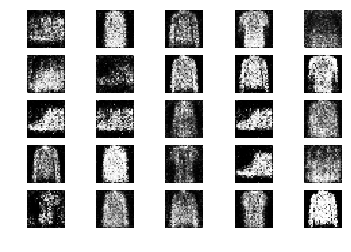

2001 [D loss: 0.651319, acc.: 53.12%] [G loss: 0.936962]
2002 [D loss: 0.632598, acc.: 62.50%] [G loss: 0.921115]
2003 [D loss: 0.685580, acc.: 57.81%] [G loss: 0.942628]
2004 [D loss: 0.617845, acc.: 64.06%] [G loss: 0.950435]
2005 [D loss: 0.664851, acc.: 57.81%] [G loss: 0.873001]
2006 [D loss: 0.594837, acc.: 75.00%] [G loss: 0.898997]
2007 [D loss: 0.608754, acc.: 71.88%] [G loss: 0.763844]
2008 [D loss: 0.644210, acc.: 70.31%] [G loss: 0.878710]
2009 [D loss: 0.626377, acc.: 67.19%] [G loss: 0.800371]
2010 [D loss: 0.576451, acc.: 67.19%] [G loss: 0.958617]
2011 [D loss: 0.634652, acc.: 64.06%] [G loss: 0.876215]
2012 [D loss: 0.652927, acc.: 62.50%] [G loss: 1.047302]
2013 [D loss: 0.654759, acc.: 54.69%] [G loss: 0.955300]
2014 [D loss: 0.635557, acc.: 67.19%] [G loss: 0.966131]
2015 [D loss: 0.638098, acc.: 64.06%] [G loss: 0.965634]
2016 [D loss: 0.676026, acc.: 60.94%] [G loss: 0.990814]
2017 [D loss: 0.661440, acc.: 60.94%] [G loss: 0.853781]
2018 [D loss: 0.627100, acc.: 6

2147 [D loss: 0.608976, acc.: 65.62%] [G loss: 0.856229]
2148 [D loss: 0.674331, acc.: 54.69%] [G loss: 0.977352]
2149 [D loss: 0.616112, acc.: 71.88%] [G loss: 0.884030]
2150 [D loss: 0.646189, acc.: 68.75%] [G loss: 0.918706]
2151 [D loss: 0.602710, acc.: 64.06%] [G loss: 0.889927]
2152 [D loss: 0.616991, acc.: 65.62%] [G loss: 0.851542]
2153 [D loss: 0.632227, acc.: 67.19%] [G loss: 0.919841]
2154 [D loss: 0.692010, acc.: 51.56%] [G loss: 0.887236]
2155 [D loss: 0.655955, acc.: 57.81%] [G loss: 0.793636]
2156 [D loss: 0.679050, acc.: 56.25%] [G loss: 0.832300]
2157 [D loss: 0.638608, acc.: 57.81%] [G loss: 0.936950]
2158 [D loss: 0.589930, acc.: 71.88%] [G loss: 0.960914]
2159 [D loss: 0.632761, acc.: 59.38%] [G loss: 0.925013]
2160 [D loss: 0.598053, acc.: 65.62%] [G loss: 0.846408]
2161 [D loss: 0.603069, acc.: 64.06%] [G loss: 0.880540]
2162 [D loss: 0.607476, acc.: 65.62%] [G loss: 0.944860]
2163 [D loss: 0.659217, acc.: 65.62%] [G loss: 0.915252]
2164 [D loss: 0.681201, acc.: 5

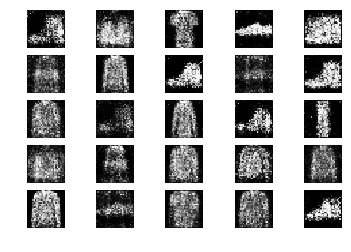

2201 [D loss: 0.708554, acc.: 46.88%] [G loss: 0.848191]
2202 [D loss: 0.673336, acc.: 56.25%] [G loss: 0.942371]
2203 [D loss: 0.639227, acc.: 64.06%] [G loss: 0.943118]
2204 [D loss: 0.621701, acc.: 64.06%] [G loss: 0.931971]
2205 [D loss: 0.646460, acc.: 56.25%] [G loss: 0.969973]
2206 [D loss: 0.652823, acc.: 59.38%] [G loss: 0.903744]
2207 [D loss: 0.634928, acc.: 64.06%] [G loss: 0.872597]
2208 [D loss: 0.710120, acc.: 57.81%] [G loss: 0.907226]
2209 [D loss: 0.657932, acc.: 65.62%] [G loss: 0.876713]
2210 [D loss: 0.620297, acc.: 64.06%] [G loss: 0.847676]
2211 [D loss: 0.587110, acc.: 75.00%] [G loss: 0.832889]
2212 [D loss: 0.616997, acc.: 70.31%] [G loss: 0.861326]
2213 [D loss: 0.662330, acc.: 59.38%] [G loss: 0.831204]
2214 [D loss: 0.625129, acc.: 67.19%] [G loss: 0.870345]
2215 [D loss: 0.647888, acc.: 59.38%] [G loss: 0.946096]
2216 [D loss: 0.591783, acc.: 67.19%] [G loss: 0.934463]
2217 [D loss: 0.647468, acc.: 64.06%] [G loss: 0.917434]
2218 [D loss: 0.635816, acc.: 6

2349 [D loss: 0.633950, acc.: 62.50%] [G loss: 0.846982]
2350 [D loss: 0.618840, acc.: 64.06%] [G loss: 0.991618]
2351 [D loss: 0.652838, acc.: 59.38%] [G loss: 0.907338]
2352 [D loss: 0.582829, acc.: 67.19%] [G loss: 0.858003]
2353 [D loss: 0.654202, acc.: 54.69%] [G loss: 0.990395]
2354 [D loss: 0.693576, acc.: 54.69%] [G loss: 0.810356]
2355 [D loss: 0.640392, acc.: 65.62%] [G loss: 0.926474]
2356 [D loss: 0.624193, acc.: 67.19%] [G loss: 0.842569]
2357 [D loss: 0.597646, acc.: 68.75%] [G loss: 0.825675]
2358 [D loss: 0.682471, acc.: 64.06%] [G loss: 0.863345]
2359 [D loss: 0.653679, acc.: 56.25%] [G loss: 0.877405]
2360 [D loss: 0.637769, acc.: 68.75%] [G loss: 0.932576]
2361 [D loss: 0.669294, acc.: 56.25%] [G loss: 0.945172]
2362 [D loss: 0.649204, acc.: 59.38%] [G loss: 0.874169]
2363 [D loss: 0.689352, acc.: 53.12%] [G loss: 0.851891]
2364 [D loss: 0.661955, acc.: 64.06%] [G loss: 0.851808]
2365 [D loss: 0.555147, acc.: 81.25%] [G loss: 0.940807]
2366 [D loss: 0.615491, acc.: 6

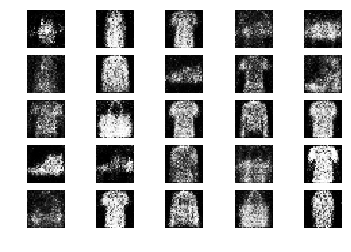

2401 [D loss: 0.596147, acc.: 73.44%] [G loss: 0.890246]
2402 [D loss: 0.693274, acc.: 48.44%] [G loss: 0.884286]
2403 [D loss: 0.671394, acc.: 54.69%] [G loss: 0.929997]
2404 [D loss: 0.612996, acc.: 67.19%] [G loss: 0.932258]
2405 [D loss: 0.642153, acc.: 62.50%] [G loss: 0.969674]
2406 [D loss: 0.671452, acc.: 57.81%] [G loss: 0.906849]
2407 [D loss: 0.627788, acc.: 64.06%] [G loss: 0.949274]
2408 [D loss: 0.563381, acc.: 75.00%] [G loss: 0.897815]
2409 [D loss: 0.602447, acc.: 70.31%] [G loss: 0.841746]
2410 [D loss: 0.620655, acc.: 65.62%] [G loss: 0.937774]
2411 [D loss: 0.598722, acc.: 62.50%] [G loss: 1.054937]
2412 [D loss: 0.691310, acc.: 54.69%] [G loss: 0.931565]
2413 [D loss: 0.571860, acc.: 71.88%] [G loss: 0.957330]
2414 [D loss: 0.686796, acc.: 54.69%] [G loss: 0.982303]
2415 [D loss: 0.671016, acc.: 64.06%] [G loss: 1.003729]
2416 [D loss: 0.701055, acc.: 56.25%] [G loss: 0.827653]
2417 [D loss: 0.684074, acc.: 53.12%] [G loss: 0.873125]
2418 [D loss: 0.611398, acc.: 7

2553 [D loss: 0.569457, acc.: 75.00%] [G loss: 0.905439]
2554 [D loss: 0.629519, acc.: 62.50%] [G loss: 0.853804]
2555 [D loss: 0.668174, acc.: 59.38%] [G loss: 0.863785]
2556 [D loss: 0.617640, acc.: 67.19%] [G loss: 0.944030]
2557 [D loss: 0.685789, acc.: 59.38%] [G loss: 0.773506]
2558 [D loss: 0.567803, acc.: 71.88%] [G loss: 0.915903]
2559 [D loss: 0.677510, acc.: 54.69%] [G loss: 0.969295]
2560 [D loss: 0.643972, acc.: 62.50%] [G loss: 0.948327]
2561 [D loss: 0.653173, acc.: 54.69%] [G loss: 0.976268]
2562 [D loss: 0.641361, acc.: 62.50%] [G loss: 1.014334]
2563 [D loss: 0.633654, acc.: 60.94%] [G loss: 0.952806]
2564 [D loss: 0.649034, acc.: 54.69%] [G loss: 0.840989]
2565 [D loss: 0.595647, acc.: 71.88%] [G loss: 0.818877]
2566 [D loss: 0.606163, acc.: 65.62%] [G loss: 0.923121]
2567 [D loss: 0.705720, acc.: 53.12%] [G loss: 0.851365]
2568 [D loss: 0.639436, acc.: 56.25%] [G loss: 0.885542]
2569 [D loss: 0.592349, acc.: 67.19%] [G loss: 0.884309]
2570 [D loss: 0.656784, acc.: 5

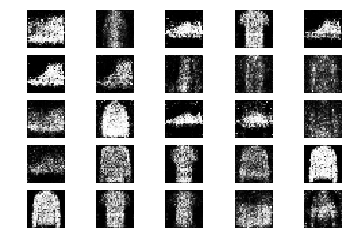

2601 [D loss: 0.697298, acc.: 59.38%] [G loss: 0.841154]
2602 [D loss: 0.633926, acc.: 62.50%] [G loss: 0.841434]
2603 [D loss: 0.606613, acc.: 65.62%] [G loss: 0.839276]
2604 [D loss: 0.595626, acc.: 68.75%] [G loss: 0.887257]
2605 [D loss: 0.636645, acc.: 64.06%] [G loss: 0.902797]
2606 [D loss: 0.652798, acc.: 67.19%] [G loss: 0.902326]
2607 [D loss: 0.629626, acc.: 71.88%] [G loss: 0.887747]
2608 [D loss: 0.618730, acc.: 54.69%] [G loss: 0.963589]
2609 [D loss: 0.656523, acc.: 60.94%] [G loss: 0.883126]
2610 [D loss: 0.611697, acc.: 71.88%] [G loss: 1.005040]
2611 [D loss: 0.614107, acc.: 64.06%] [G loss: 0.965258]
2612 [D loss: 0.666927, acc.: 57.81%] [G loss: 0.948128]
2613 [D loss: 0.639978, acc.: 68.75%] [G loss: 0.981634]
2614 [D loss: 0.598153, acc.: 67.19%] [G loss: 0.882715]
2615 [D loss: 0.656337, acc.: 59.38%] [G loss: 0.883889]
2616 [D loss: 0.636701, acc.: 60.94%] [G loss: 0.871948]
2617 [D loss: 0.658959, acc.: 60.94%] [G loss: 0.840167]
2618 [D loss: 0.614581, acc.: 6

2752 [D loss: 0.638966, acc.: 65.62%] [G loss: 0.945498]
2753 [D loss: 0.669208, acc.: 59.38%] [G loss: 0.932385]
2754 [D loss: 0.612473, acc.: 68.75%] [G loss: 1.021392]
2755 [D loss: 0.613463, acc.: 70.31%] [G loss: 0.906433]
2756 [D loss: 0.613966, acc.: 64.06%] [G loss: 0.871143]
2757 [D loss: 0.681857, acc.: 60.94%] [G loss: 0.962090]
2758 [D loss: 0.612187, acc.: 70.31%] [G loss: 0.846905]
2759 [D loss: 0.586235, acc.: 67.19%] [G loss: 0.940260]
2760 [D loss: 0.615109, acc.: 65.62%] [G loss: 0.963881]
2761 [D loss: 0.707232, acc.: 51.56%] [G loss: 0.948653]
2762 [D loss: 0.621601, acc.: 71.88%] [G loss: 0.935555]
2763 [D loss: 0.549019, acc.: 76.56%] [G loss: 0.918283]
2764 [D loss: 0.672321, acc.: 57.81%] [G loss: 1.014497]
2765 [D loss: 0.616661, acc.: 65.62%] [G loss: 0.914725]
2766 [D loss: 0.674077, acc.: 50.00%] [G loss: 0.890087]
2767 [D loss: 0.594786, acc.: 68.75%] [G loss: 0.878197]
2768 [D loss: 0.717610, acc.: 57.81%] [G loss: 0.981192]
2769 [D loss: 0.654213, acc.: 6

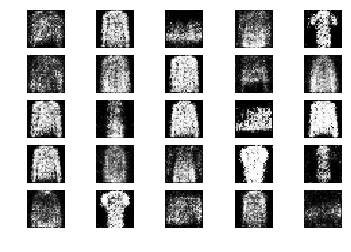

2801 [D loss: 0.561654, acc.: 68.75%] [G loss: 0.954466]
2802 [D loss: 0.653201, acc.: 62.50%] [G loss: 0.901519]
2803 [D loss: 0.524388, acc.: 75.00%] [G loss: 0.912049]
2804 [D loss: 0.667669, acc.: 65.62%] [G loss: 0.983211]
2805 [D loss: 0.656136, acc.: 62.50%] [G loss: 0.946788]
2806 [D loss: 0.537802, acc.: 79.69%] [G loss: 0.877949]
2807 [D loss: 0.721274, acc.: 48.44%] [G loss: 0.947426]
2808 [D loss: 0.609888, acc.: 73.44%] [G loss: 0.924698]
2809 [D loss: 0.657057, acc.: 62.50%] [G loss: 0.870096]
2810 [D loss: 0.699635, acc.: 54.69%] [G loss: 0.936465]
2811 [D loss: 0.593439, acc.: 59.38%] [G loss: 0.835047]
2812 [D loss: 0.694172, acc.: 56.25%] [G loss: 0.903918]
2813 [D loss: 0.615036, acc.: 68.75%] [G loss: 0.882911]
2814 [D loss: 0.618181, acc.: 70.31%] [G loss: 0.870675]
2815 [D loss: 0.597360, acc.: 68.75%] [G loss: 0.921709]
2816 [D loss: 0.627167, acc.: 60.94%] [G loss: 0.871884]
2817 [D loss: 0.635797, acc.: 62.50%] [G loss: 0.858038]
2818 [D loss: 0.622144, acc.: 6

2951 [D loss: 0.631136, acc.: 57.81%] [G loss: 0.836976]
2952 [D loss: 0.613018, acc.: 70.31%] [G loss: 0.906461]
2953 [D loss: 0.622107, acc.: 59.38%] [G loss: 0.842965]
2954 [D loss: 0.643285, acc.: 56.25%] [G loss: 0.883100]
2955 [D loss: 0.644758, acc.: 59.38%] [G loss: 0.930330]
2956 [D loss: 0.710140, acc.: 60.94%] [G loss: 0.898199]
2957 [D loss: 0.656533, acc.: 64.06%] [G loss: 1.003568]
2958 [D loss: 0.638617, acc.: 67.19%] [G loss: 0.974739]
2959 [D loss: 0.644482, acc.: 62.50%] [G loss: 1.011757]
2960 [D loss: 0.551816, acc.: 75.00%] [G loss: 0.975537]
2961 [D loss: 0.727937, acc.: 43.75%] [G loss: 0.923945]
2962 [D loss: 0.591452, acc.: 71.88%] [G loss: 0.897514]
2963 [D loss: 0.574584, acc.: 68.75%] [G loss: 0.867445]
2964 [D loss: 0.579049, acc.: 73.44%] [G loss: 0.919119]
2965 [D loss: 0.598535, acc.: 70.31%] [G loss: 0.940229]
2966 [D loss: 0.601438, acc.: 65.62%] [G loss: 0.959047]
2967 [D loss: 0.626946, acc.: 65.62%] [G loss: 0.887486]
2968 [D loss: 0.596485, acc.: 6

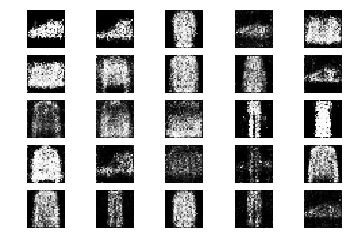

In [11]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=3000, batch_size=32, sample_interval=200)